<a href="https://colab.research.google.com/github/MartaSolarz/KMeans_algorithm_grouping_data/blob/main/K_Means_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grouping data using the K-Means algorithm**



---







![Picture](https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/ClusterAnalysis_Mouse.svg/1920px-ClusterAnalysis_Mouse.svg.png)

Source: *https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/ClusterAnalysis_Mouse.svg/1920px-ClusterAnalysis_Mouse.svg.png*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import yaml

### Getting data from the PostgreSQL database

In [ ]:
YAML = '/content/drive/MyDrive/Colab Notebooks/Code:me_data_science/data/credits.yaml'  

In [ ]:
with open(YAML, 'r') as stream:
  settings = yaml.safe_load(stream)

FileNotFoundError: ignored

In [ ]:
def connect_to_postgres(db_user, db_pass, db_host, db_port, db_name, db_table):
    # Krok 1 - identyfikacja użytkownika
    db_connection_str = 'postgresql://{}:{}@{}:{}/{}'.format(
        db_user, db_pass, db_host, db_port, db_name
    )
    # Krok 2 - podłączenie do tabelki - db_connection będzie przechowywać to połączenie
    db_connection = create_engine(db_connection_str)

    # Krok 3 - zapytanie SQL - pobranie danych (ściągnięcie wszystkich danych)
    query = 'SELECT * FROM {}'.format(db_table)
    
    # Krok 4 - tworzenie ramki danych
    df = pd.read_sql(query, con=db_connection)

    # Krok 5 - odłączenie się od bazy
    db_connection.dispose()

    return df

In [ ]:
df = connect_to_postgres(**settings)

### Getting data from a saved CSV file (when the connection didn't work or don't have permission)

In [ ]:
CSV_FILE = '/content/drive/MyDrive/Colab Notebooks/usa_processed.csv'

In [ ]:
df = pd.read_csv(
    CSV_FILE
)
df.columns

Index(['County', ' FIPS', 'Met Healthy People Objective of ***?',
       'Age-Adjusted Incidence Rate([rate note]) - cases per 100,000',
       'Lower 95% Confidence Interval', 'Upper 95% Confidence Interval',
       'CI*Rank([rank note])', 'Lower CI (CI*Rank)', 'Upper CI (CI*Rank)',
       'Average Annual Count', 'Recent Trend',
       'Recent 5-Year Trend ([trend note]) in Incidence Rates',
       'Lower 95% Confidence Interval.1', 'Upper 95% Confidence Interval.1'],
      dtype='object')



---



---



## 1. Data preparation

In [ ]:
df = pd.read_csv(
    CSV_FILE,
    usecols=[' FIPS', 'Age-Adjusted Incidence Rate([rate note]) - cases per 100,000', 'Lower 95% Confidence Interval', 'Upper 95% Confidence Interval'],
    dtype={' FIPS':int},
    na_values=['*', '[P1 note] ']
).rename(columns={' FIPS':'fips', 
                  'Age-Adjusted Incidence Rate([rate note]) - cases per 100,000':'rate', 
                  'Lower 95% Confidence Interval':'< 95% CI', 
                  'Upper 95% Confidence Interval':'> 95% CI'
}).dropna().set_index('fips').sort_index()

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2715 entries, 0 to 72001
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   rate      2715 non-null   object
 1   < 95% CI  2715 non-null   object
 2   > 95% CI  2715 non-null   object
dtypes: object(3)
memory usage: 516.5 KB


In [ ]:
df['rate'] = df['rate'].map(lambda x: x.replace('#', ''))
df['rate'] = df['rate'].astype(float)

In [ ]:
df['< 95% CI'] = df['< 95% CI'].astype(float)
df['> 95% CI'] = df['> 95% CI'].astype(float)

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2715 entries, 0 to 72001
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rate      2715 non-null   float64
 1   < 95% CI  2715 non-null   float64
 2   > 95% CI  2715 non-null   float64
dtypes: float64(3)
memory usage: 84.8 KB


In [ ]:
df.sample(5)

,rate,< 95% CI,> 95% CI
fips,,,
23029,112.6,93.3,135.2
1115,137.0,123.0,152.3
28067,119.3,104.8,135.2
13047,88.3,76.0,102.2
8059,133.2,127.7,138.9


In [ ]:
df.nunique() / len(df)

rate        0.296869
< 95% CI    0.327072
> 95% CI    0.346225
dtype: float64

In [ ]:
df.describe(percentiles=[.01, .25, .50, .75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
rate,2715.0,119.947514,20.120186,51.2,69.514,107.3,121.0,132.8,167.586,242.6
< 95% CI,2715.0,97.426004,22.413722,28.0,44.784,82.0,99.2,113.9,142.516,175.4
> 95% CI,2715.0,148.263757,27.705538,70.0,96.626,131.4,143.6,159.1,238.172,382.0


In [ ]:
_test_rate_upper_than_99 = df['rate'] > 167.586
len(df[_test_rate_upper_than_99])

28

In [ ]:
_test_CI_upper_95_upper_99 = df['> 95% CI'] > 238.172
len(_test_CI_upper_95_upper_99)

2715

In [ ]:
_test_zero = df['rate'] < 100
len(df[_test_zero]) == sum(_test_zero)

True

In [ ]:
states = df.loc[0]
index_states = states.name  
values = df.index.isin([index_states])
counties = df.iloc[~values]

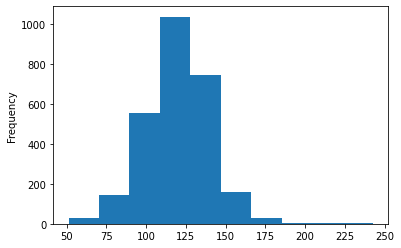

In [ ]:
counties['rate'].plot(kind='hist');

In [ ]:
counties.isna().any()

rate        False
< 95% CI    False
> 95% CI    False
dtype: bool

In [ ]:
sum(counties.isna().any(axis=1))

0

In [ ]:
counties.to_csv('/content/drive/MyDrive/Colab Notebooks/usa_processed_cleared_data.csv')

________________________________________________________________________________________________________________________________________________________________

## 2. Construction of model

In [ ]:
import numpy as np 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 

In [ ]:
counties.var()  # data scaling

rate        404.958041
< 95% CI    502.265334
> 95% CI    767.700282
dtype: float64

In [ ]:
model_input = counties.values
model_input

array([[129.9, 113.2, 148.5],
       [128.1, 119.6, 137.2],
       [107.9,  85.1, 135.3],
       ...,
       [130.2,  87.5, 187.4],
       [129.2,  84.3, 191.3],
       [ 91.6,  89.8,  93.4]])

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(model_input) 
scaled_data.var()

1.0

In [ ]:
# KMEANS MODEL
class ClusteredData:
    
    def __init__(self, dataset):
        self.ds = dataset
        self.no_of_ranges = None
        self.models = []
        self.predicted_labels = {}
        self.s_scores = []
        self.inertia_scores = []
        
    def build_models(self, no_of_clusters_range: list, update_input_labels=True):
        self.no_of_ranges = no_of_clusters_range
        for n_clust in no_of_clusters_range:
            kmeans = KMeans(n_clusters=n_clust)
            y_pred = kmeans.fit_predict(self.ds)
            
            # Append model
            self.models.append(kmeans)
            
            # Calculate metrics
            self.s_scores.append(self._calc_s_score(y_pred))
            self.inertia_scores.append(kmeans.inertia_)
            
            # Append output (classified)
            if update_input_labels:
                self.predicted_labels[n_clust] = y_pred
        
    def _calc_s_score(self, labels):
        s_score = silhouette_score(self.ds, labels, sample_size=1000)
        return s_score
            
    def show_inertia(self):
        plt.figure(figsize = (10,10))
        plt.title('Inertia of the models')
        plt.plot(self.no_of_ranges, self.inertia_scores)
        plt.show()
        
    def show_silhouette_scores(self):
        plt.figure(figsize = (10,10))
        plt.title('Silhouette scores')
        plt.plot(self.no_of_ranges, self.s_scores)
        plt.show()

In [ ]:
models = ClusteredData(scaled_data)
batch_clusters = [3,4,5,10,20,30]
models.build_models(batch_clusters)

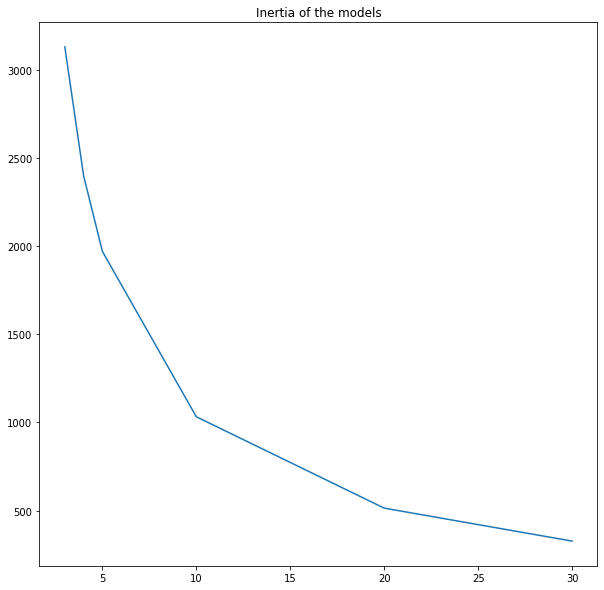

In [ ]:
models.show_inertia()

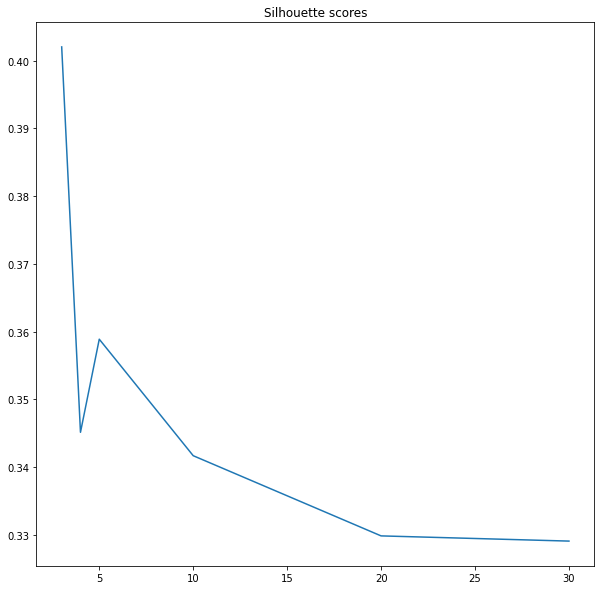

In [ ]:
models.show_silhouette_scores()

In [ ]:
labels_counties = pd.DataFrame(models.predicted_labels, index=counties.index)
labels_counties

,3,4,5,10,20,30
fips,,,,,,
1001,0,0,1,2,19,1
1003,0,0,1,2,14,28
1005,1,1,3,1,10,3
1007,2,0,1,6,16,16
1009,0,0,1,2,19,1
...,...,...,...,...,...,...
56039,2,0,1,5,16,16
56041,2,0,1,8,16,16
56043,2,2,0,9,12,27


In [ ]:
labels_counties[5].value_counts()

1    828
3    809
4    471
0    389
2    217
Name: 5, dtype: int64

In [ ]:
class_0 = counties[labels_counties[5] == 0]
class_1 = counties[labels_counties[5] == 1]
class_2 = counties[labels_counties[5] == 2]
class_3 = counties[labels_counties[5] == 3]
class_4 = counties[labels_counties[5] == 4]

In [ ]:
# Raport
print('Class 0:')
print(class_0.describe().T)
print()
print('Class 1:')
print(class_1.describe().T)
print()
print('Class 2:')
print(class_2.describe().T)
print()
print('Class 3:')
print(class_3.describe().T)
print()
print('Class 4:')
print(class_4.describe().T)

Class 0:
          count        mean        std    min    25%    50%    75%    max
rate      389.0  117.160154   8.921957   96.7  110.2  118.3  123.8  135.4
< 95% CI  389.0   81.086889  11.516790   53.8   72.7   82.1   91.2   99.8
> 95% CI  389.0  166.135476  14.240045  143.7  155.8  163.2  173.8  224.3

Class 1:
          count        mean        std    min      25%     50%      75%    max
rate      828.0  134.608454   6.962381  123.2  128.900  133.50  139.325  157.4
< 95% CI  828.0  119.454831  10.222511   99.8  112.100  118.75  125.825  147.9
> 95% CI  828.0  151.742391  12.054385  127.1  142.875  150.25  159.425  182.3

Class 2:
          count        mean        std    min    25%    50%    75%    max
rate      217.0  154.017512  16.995004  130.5  143.2  150.7  159.5  242.6
< 95% CI  217.0  110.008756  18.691756   71.4   97.1  109.1  122.1  175.4
> 95% CI  217.0  212.769585  28.467304  181.2  193.3  206.7  222.5  382.0

Class 3:
          count        mean       std    min    25%  